<img align="right" src="https://raw.githubusercontent.com/dcblum/OpenStreetMap/master/IrvineMapBoundaries.PNG" title="Irvine Map Extract Area">

# OpenStreetMap Case Study with SQL

### Map Area: Irvine, California

City Boundaries:
* https://www.openstreetmap.org/relation/114485

Map Extract Website:
* https://mapzen.com/data/metro-extracts-alt/

The Map Extract data extends beyond Irvine City limits in the shape of a rectangle. For the purpose of this dataset the any data in the given rectangular picture is considered to be in Irvine.

#### Contents
 - [Problems Encountered](#problems-encountered)

### Problems Encountered:

After running the data agaisnt the given data.py file, a few problems were found:
* Inconsistent use of abbreviations: ex. "Rd.", "Rd", and "Road" to all indicate "Road"
* Use of "St." indicating both "Street" and "Saint"
* Unicode street and postcode data containing (street = 'Rue Jean Jaur\xe8s' and postcode = '92626\xad)
* Postcode data contaning non-integer characters such as letters and hyphens: ex. "CA 92701" and "92610-3437"

 Number of Unique Users:
        2315

### Street Names:

The OSM file of Irvine was audited via audit.py to help correct inconsistent use of abbreviations. 

To help filter results, all street names contained in list "expected" were skipped during the auditing process. Names were added by the user to the "expected" list after each audit to further filter results.

In [203]:
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", "Trail", "Parkway", "Ridge", 
            "Commons", "Way", "Vista", "Terrace", "Circle", "Glen", "Grove", "Hill", "South", "East", "West", "North", "Tree", 
            "Valley", "Creek", "Canyon", "Brook", "Bloom", "Springs", "Verde", "Arbor", "Center", "Loop"]

In [216]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Fetch records from the database
db = sqlite3.connect("IrvineMaps.db")
c = db.cursor()
QUERY = ( 
    "SELECT tags.value, COUNT(*) as count "
    "FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags "
    "WHERE tags.key='postcode' "
    "GROUP BY tags.value "
    "ORDER BY count DESC "
    "LIMIT 10;"
    )
c.execute(QUERY)
rows = c.fetchall()
    
postcodes_df = pd.DataFrame(rows)
postcodes_df.columns = ['Postcode', 'Count']
from IPython.display import display, HTML
display(HTML(postcodes_df.to_html(index=False)))

Postcode,Count
92630,14813
92620,7506
92618,7236
92602,4780
92606,2350
92610,1601
92604,992
92614,869
92603,738
92782,700


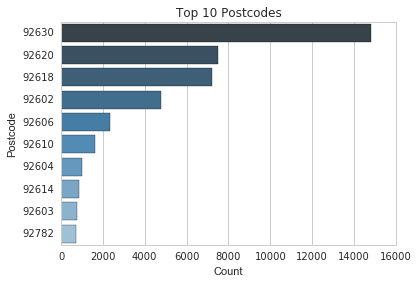

In [205]:
sns.barplot(x=postcodes_df['Count'], y=postcodes_df["Postcode"], orient='h', order = postcodes_df['Postcode'], palette="Blues_d")
sns.axlabel("Count", "Postcode")

plt.title("Top 10 Postcodes")
plt.show()

In [206]:
QUERY = ( 
    "SELECT tags.value, COUNT(*) as count "
    "FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags "
    "WHERE tags.key LIKE '%city' "
    "GROUP BY tags.value "
    "ORDER BY count DESC "
    "LIMIT 10;"
    )
c.execute(QUERY)
rows = c.fetchall()
    
cities_df = pd.DataFrame(rows)
cities_df.columns = ['City', 'Count']
print cities_df

                 City  Count
0              Irvine  25346
1         Lake Forest  14552
2      Foothill Ranch   1601
3              Tustin   1012
4  Wólka Niedźwiedzka    116
5           Santa Ana    106
6              Orange     92
7       Mission Viejo     60
8          Costa Mesa     54
9       Newport Beach     40


In [208]:
from IPython.display import display, HTML
display(HTML(cities_df.to_html(index=False)))

City,Count
Irvine,25346
Lake Forest,14552
Foothill Ranch,1601
Tustin,1012
Wólka Niedźwiedzka,116
Santa Ana,106
Orange,92
Mission Viejo,60
Costa Mesa,54
Newport Beach,40
